# Analyzing Bitcoin Sentiment on Reddit: Insights from User Discussions

# Overview
This project delves into public sentiment towards Bitcoin by analyzing recent discussions on Reddit. We collected the latest 500 posts and their 15,712 associated comments, primarily from the period of October 14th to October 23rd, 2024, within the Bitcoin subreddit. Our analysis focuses on sentiment trends and key terms related to Bitcoin, aiming to provide a deeper understanding of user perceptions and sentiment shifts over time.

Index:

0. Install Packages
1. Create MySQL Database
2. Obtain Data on Reddit
3. EDA
4. Data Cleaning
5. Sentiment Analyzing
6. Insights

# 0. Install Packages

In [ ]:
!pip install ipython-sql pymysql
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install praw
!pip install sqlalchemy
!pip install vaderSentiment
!pip install wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

# 1. Create MySQL Database
We use SQL to store our data, allowing for more efficient organization, querying, and analysis of the sentiment trends and key insights from the Reddit discussions.

In [134]:
load_dotenv()

# Get .env variables
db_username = os.getenv('DB_USERNAME')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

# Setup MySQL connection
engine = create_engine(
    f'mysql+pymysql://{db_username}:{db_password}@{db_host}',
    isolation_level='AUTOCOMMIT'
)

# Create database
with engine.connect() as conn:
    conn.execute(text("CREATE DATABASE IF NOT EXISTS reddit_analysis;"))
    conn.execute(text("USE reddit_analysis;")) 

# Reconnect to the specific database
engine = create_engine(
    f'mysql+pymysql://{db_username}:{db_password}@{db_host}/{db_name}',
    isolation_level='AUTOCOMMIT'
)

We design two tables, `Posts` and `Comments`, to maintain a clear data structure, linking them through the `post_id` for easy reference and relationship management between posts and their corresponding comments.

In [135]:

with engine.connect() as conn:
    # Create Posts table
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS Posts (
            post_id VARCHAR(10) PRIMARY KEY,
            post_title TEXT,
            post_self_text TEXT,
            post_created_time DATETIME,
            post_score INT,
            post_upvote_ratio FLOAT,
            post_num_comments INT
        );
        """))
    # Create Comments table
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS Comments (
            comment_id VARCHAR(10) PRIMARY KEY,
            post_id VARCHAR(10),
            self_text TEXT,
            score INT,
            created_time DATETIME,
            author_name VARCHAR(50),
            FOREIGN KEY (post_id) REFERENCES Posts(post_id)
        );
        """))
print("Database and tables have been successfully created.")

Database and tables have been successfully created.


# 2. Obtain Data on Reddit
We collected the latest 500 posts and their corresponding comments from the Bitcoin subreddit on Reddit.

In [136]:
import praw

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id = os.getenv('REDDIT_CLIENT_ID'),        # client_id from the Reddit application
    client_secret = os.getenv('REDDIT_CLIENT_SECRET'), # client_secret from the Reddit application
    user_agent = os.getenv('REDDIT_USER_AGENT'),      # A string that describes the application's purpose
)

In [137]:

comments = []
posts = []

# Bitcoin subreddit
subreddit = reddit.subreddit('Bitcoin')
submissions = subreddit.hot(limit=500)

for submission in submissions:
        # Get posts
        posts.append({
            'post_id': submission.id,
            'post_title': submission.title,
            'post_self_text': submission.selftext,
            'post_created_time': datetime.fromtimestamp(int(submission.created_utc)),
            'post_score': submission.score,
            'post_upvote_ratio': submission.upvote_ratio,
            'post_num_comments': submission.num_comments,
        })

        
        # Get comments
        submission.comments.replace_more(limit=0) 
        for comment in submission.comments.list():
            comments.append({
                'comment_id': comment.id,
                'score': comment.score,
                'self_text': comment.body,
                'created_time': datetime.fromtimestamp(int(comment.created_utc)),
                'post_id': submission.id,
                'author_name': comment.author.name if comment.author else 'deleted'
            })

# Convert to pandas dataframe
df_posts = pd.DataFrame(posts)
df_comments = pd.DataFrame(comments)

# Save posts data into the SQL database
df_posts.to_sql('Posts', con=engine, if_exists='append', index=False)

# Save comments data into the SQL database
df_comments.to_sql('Comments', con=engine, if_exists='append', index=False)

# 3. EDA

In [231]:
print(f'Number of posts: {len(df_posts)}')
print(f'Number of comments from these posts: {len(df_comments)}')

Number of posts: 500
Number of comments from these posts: 15712


In [145]:
df_posts.head()

,post_id,post_title,post_self_text,post_created_time,post_score,post_upvote_ratio,post_num_comments
0,1f7n947,Bitcoin Newcomers FAQ - Please read!,# Welcome to the /r/Bitcoin Newcomers FAQ\n\nY...,2024-09-02 21:05:33,36,0.97,13
1,1gavwe2,"Daily Discussion, October 24, 2024",Please utilize this sticky thread for all gene...,2024-10-24 02:05:41,12,0.83,23
2,1gax8sb,You can buy bitcoin at every train station in ...,,2024-10-24 03:47:19,649,0.98,59
3,1gb1v5s,US Federal Reserve Debt is going parabolic and...,,2024-10-24 08:51:02,121,0.85,28
4,1gb3t3r,Is it just me or has the Bitcoin narrative shi...,"Like, remember when Bitcoin was all about sepa...",2024-10-24 10:22:36,75,0.82,85


In [144]:
df_comments.head()

,comment_id,score,self_text,created_time,post_id,author_name
0,ll8i6es,1,Please feel free to make [constructive edits](...,2024-09-02 21:05:50,1f7n947,BitcoinFan7
1,lth017v,7,☕️,2024-10-24 02:11:58,1gavwe2,Argyrus777
2,lthsyes,9,"In the last four years 1,800 ETFs have launche...",2024-10-24 07:15:15,1gavwe2,harvested
3,lth6wbg,8,Wyoming reserve coming?,2024-10-24 03:24:31,1gavwe2,harvested
4,lth4a1d,4,Crabcoin! 🦀,2024-10-24 02:55:59,1gavwe2,LastRecognition4151


Let's check out the daily Post Volume Over the Past Month:

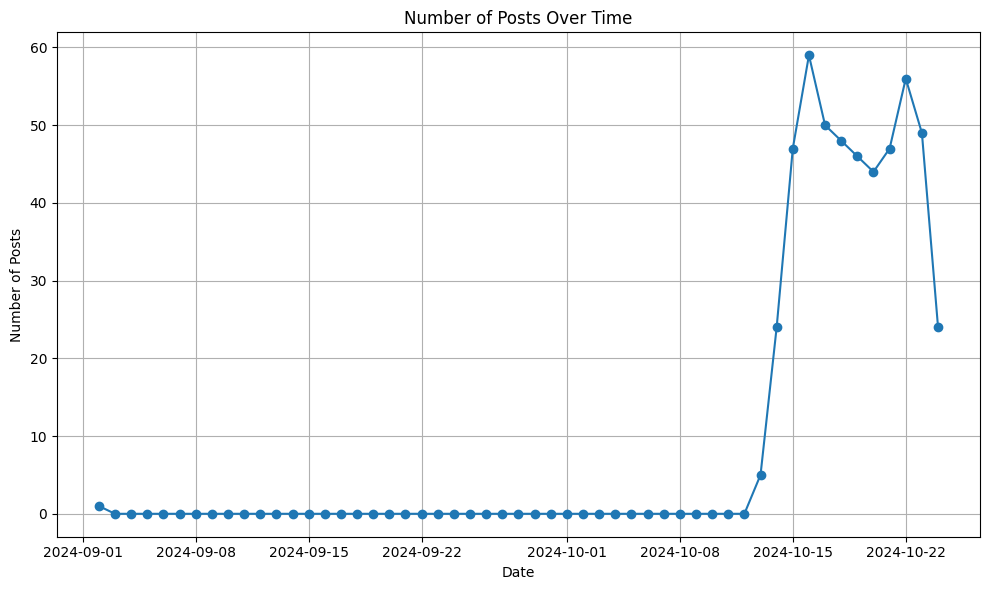

In [230]:
with engine.connect() as conn:
    post_time_df = pd.read_sql("""SELECT post_created_time FROM posts""", conn)
time_series = post_time_df.resample('D', on='post_created_time').size()

plt.figure(figsize=(10,6))
plt.plot(time_series.index, time_series.values, marker='o', linestyle='-')
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's dive into the word cloud to see which topic are being discussed the most:

(np.float64(-0.5), np.float64(999.5), np.float64(599.5), np.float64(-0.5))

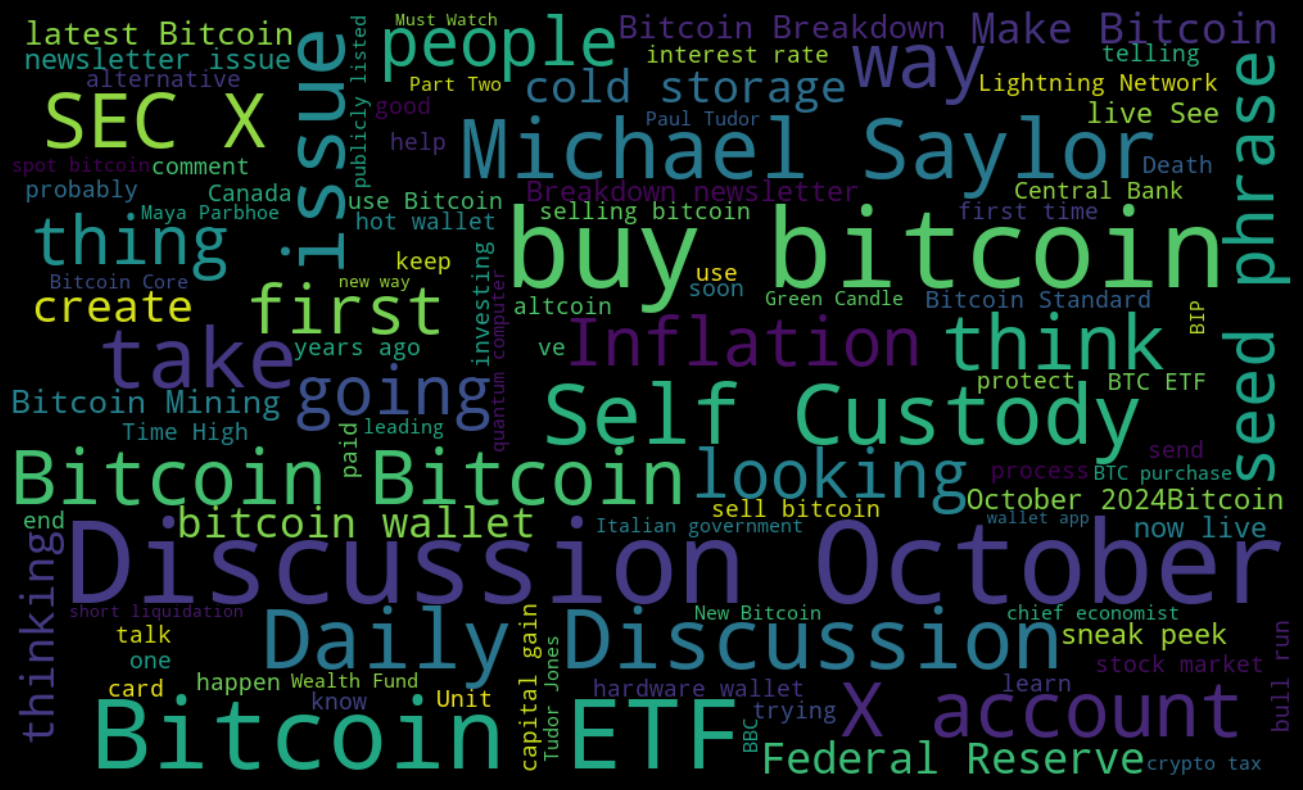

In [202]:
stopwords = STOPWORDS

text = ''.join( [title for title in df_posts['post_title']] )
text = text.join( [txt for txt in df_comments['self_text']] )
                  
wordcloud = WordCloud(
    width=1000, height = 600, 
    max_words = 100,
    stopwords = stopwords,
    background_color='black').generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Insights:

The word cloud highlights key topics driving conversations in the Bitcoin community on Reddit. Prominent terms like buy bitcoin and ETF reflect a strong focus on investment strategies. 

Michael Saylor and Self Custody are also widely discussed, especially following Saylor’s recent comments. The MicroStrategy CEO suggested that big banks should take custody of Bitcoin, but, after facing backlash, he reversed his stance. On October 23, he posted on X: “I support self-custody for those willing and able, the right to self-custody for all, and freedom to choose the form of custody and custodian for individuals and institutions globally.” It’s interesting to see that our analysis highlights keywords and topics that are currently trending.

Mentions of the SEC and Federal Reserve indicate that users are closely following external regulatory influences on Bitcoin’s future. Security remains a major theme, with terms like Seed phrase and cold storage underscoring the community’s focus on safe storage practices. Additionally, economic terms such as Inflation and interest rate suggest that many view Bitcoin within the broader context of global financial trends. Frequent references to October and Daily Discussion reveal active engagement with recent events and market updates. Overall, the discussions are centered on investment, security, and the impacts of economic and regulatory developments.

# 4. Data Cleaning

In [148]:
# Get post_id, post_title from posts table and comment_id, self_text from comments table
def getDataFrameForSentimentAnalysis():
    with engine.connect() as conn:
        df_post_sentiment = pd.read_sql(text("SELECT post_id, post_title FROM posts"), conn)
        df_comment_sentiment = pd.read_sql(text("SELECT comment_id, self_text FROM comments"), conn)
        return df_post_sentiment, df_comment_sentiment
df_post_sentiment, df_comment_sentiment = getDataFrameForSentimentAnalysis()

In [149]:
df_post_sentiment.head()

,post_id,post_title
0,1f7n947,Bitcoin Newcomers FAQ - Please read!
1,1g2p78o,Just came across this while walking through th...
2,1g2tg1m,These Bitcoin ATMs are everywhere around Times...
3,1g2vsla,You don't have to buy 1 Bitcoin
4,1g2wtno,1.0 of Bitcoin? You can’t even own a mere 0.1


In [150]:
df_comment_sentiment.head()

,comment_id,self_text
0,ll8i6es,Please feel free to make [constructive edits](...
1,lrpqbt0,This is actually brilliant
2,lrpt4lg,"If you're in Spain, and you didn't just hang u..."
3,lrpvi0e,I was in Barca recently and there are lots of ...
4,lrpvnfr,Bitcoin is truly freedom for those that need i...


Clean the text by removing unnecessary words and punctuation such as hashtags (#), retweet indicators (RT), colons (:), hyphens (-), brackets ([]), and URLs.

In [151]:
def cleanTxt(text):
    # Remove #, RT, :, -, [, ], url
    text = re.sub(r'@[A-Za-z0-9_]+|#|RT[\s]+|http\S+|www\.\S+|[:,\-\[\]]', '', text)
    return text

#Cleaning the text
df_post_sentiment['post_title']= df_post_sentiment['post_title'].apply(cleanTxt)
df_post_sentiment.head()

,post_id,post_title
0,1f7n947,Bitcoin Newcomers FAQ Please read!
1,1g2p78o,Just came across this while walking through th...
2,1g2tg1m,These Bitcoin ATMs are everywhere around Times...
3,1g2vsla,You don't have to buy 1 Bitcoin
4,1g2wtno,1.0 of Bitcoin? You can’t even own a mere 0.1


In [152]:
df_comment_sentiment['self_text']= df_comment_sentiment['self_text'].apply(cleanTxt)
df_comment_sentiment.head()

,comment_id,self_text
0,ll8i6es,Please feel free to make constructive edits( t...
1,lrpqbt0,This is actually brilliant
2,lrpt4lg,If you're in Spain and you didn't just hang up...
3,lrpvi0e,I was in Barca recently and there are lots of ...
4,lrpvnfr,Bitcoin is truly freedom for those that need i...


# 5. Sentiment Analyzing
We used VADER, a simple sentiment analysis tool, to classify the sentiment of our posts and comments.

Note: Since post content is often unavailable (frequently consisting of images or charts that aren’t retrievable from Reddit), we focused on analyzing only post titles for sentiment classification.

### About VADER:

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] 

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

Ref: https://github.com/cjhutto/vaderSentiment

In [153]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Init VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Conduct analyzing
def get_compound_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']  

In [154]:
# Apply Sentiment analyzing for post
df_post_sentiment['compound_score'] = df_post_sentiment['post_title'].apply(get_compound_score)

# Assign sentiment labels to posts based on their compound scores.
df_post_sentiment['sentiment_label'] = df_post_sentiment['compound_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

df_post_sentiment.head()

,post_id,post_title,compound_score,sentiment_label
0,1f7n947,Bitcoin Newcomers FAQ Please read!,0.3802,positive
1,1g2p78o,Just came across this while walking through th...,0.0000,neutral
2,1g2tg1m,These Bitcoin ATMs are everywhere around Times...,0.0000,neutral
3,1g2vsla,You don't have to buy 1 Bitcoin,0.0000,neutral
4,1g2wtno,1.0 of Bitcoin? You can’t even own a mere 0.1,0.0000,neutral


In [155]:
# Apply Sentiment analyzing for comments
df_comment_sentiment['compound_score'] = df_comment_sentiment['self_text'].apply(get_compound_score)

# Assign sentiment labels to comments based on their compound scores.
df_comment_sentiment['sentiment_label'] = df_comment_sentiment['compound_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

df_comment_sentiment.head()

,comment_id,self_text,compound_score,sentiment_label
0,ll8i6es,Please feel free to make constructive edits( t...,0.9661,positive
1,lrpqbt0,This is actually brilliant,0.5859,positive
2,lrpt4lg,If you're in Spain and you didn't just hang up...,0.0000,neutral
3,lrpvi0e,I was in Barca recently and there are lots of ...,0.5407,positive
4,lrpvnfr,Bitcoin is truly freedom for those that need i...,0.7964,positive


In [156]:
# Add two columns: compound_score and sentiment_label to both posts and comments table
with engine.connect() as conn:
    conn.execute(text("""
        ALTER TABLE posts 
        ADD COLUMN compound_score FLOAT,
        ADD COLUMN sentiment_label VARCHAR(10);
    """))

    conn.execute(text("""
        ALTER TABLE comments 
        ADD COLUMN compound_score FLOAT,
        ADD COLUMN sentiment_label VARCHAR(10);
    """))

In [165]:
# Create two temporary tables: posts_temp and comments_temp
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS posts_temp;"))
    conn.execute(text("DROP TABLE IF EXISTS comments_temp;"))
    conn.execute(text("""
        CREATE TABLE posts_temp (
            post_id VARCHAR(10),
            compound_score FLOAT,
            sentiment_label VARCHAR(10)
        );
    """))

    conn.execute(text("""
        CREATE TABLE comments_temp (
            comment_id VARCHAR(10),
            compound_score FLOAT,
            sentiment_label VARCHAR(10)
        );
    """))

# Save posts sentiment labels into the temporary tables
df_post_sentiment.drop('post_title', axis=1, inplace=True)
df_comment_sentiment.drop('self_text', axis=1, inplace=True)

df_post_sentiment.to_sql('posts_temp', con=engine, if_exists='append', index=False)
df_comment_sentiment.to_sql('comments_temp', con=engine, if_exists='append', index=False)


15712

In [167]:
# Move sentiment data from temporary tables (post_temp, comments_temp) to posts and comments tables.
with engine.connect() as conn:
    conn.execute(text("""
                UPDATE posts p
                JOIN posts_temp pt ON p.post_id = pt.post_id
                SET 
                p.compound_score = pt.compound_score,
                p.sentiment_label = pt.sentiment_label;
    """))

    conn.execute(text("""
                UPDATE comments c
                JOIN comments_temp ct ON c.comment_id = ct.comment_id
                SET 
                c.compound_score = ct.compound_score,
                c.sentiment_label = ct.sentiment_label;
    """))

    # Drop temporary tables
    conn.execute(text("DROP TABLE IF EXISTS posts_temp;"))
    conn.execute(text("DROP TABLE IF EXISTS comments_temp;"))

# 6. Sentiment Analysis Insights 

### Analysis 1: Sentiment Distribution Overview

We analyzed the sentiment counts (positive, neutral, negative) in both posts and comments related to Bitcoin. The chart below visualizes these counts, illustrating the distribution across posts, comments, and the overall combined totals.

In [169]:
# Calculate the count of posts and comments and group by sentiment label.
with engine.connect() as conn:
    sentiment_count_df = pd.read_sql(text("""
        SELECT p.sentiment_label, COUNT(*) AS post_count, c.comment_count
        FROM posts p
        JOIN (
            SELECT sentiment_label, COUNT(*) AS comment_count
            FROM comments
            GROUP BY sentiment_label
        ) c ON p.sentiment_label = c.sentiment_label
        GROUP BY p.sentiment_label;
    """), conn)

sentiment_count_df['total_count'] = sentiment_count_df['post_count'] + sentiment_count_df['comment_count']

sentiment_count_df.head()

,sentiment_label,post_count,comment_count,total_count
0,positive,154,6948,7102
1,neutral,283,5184,5467
2,negative,63,3580,3643


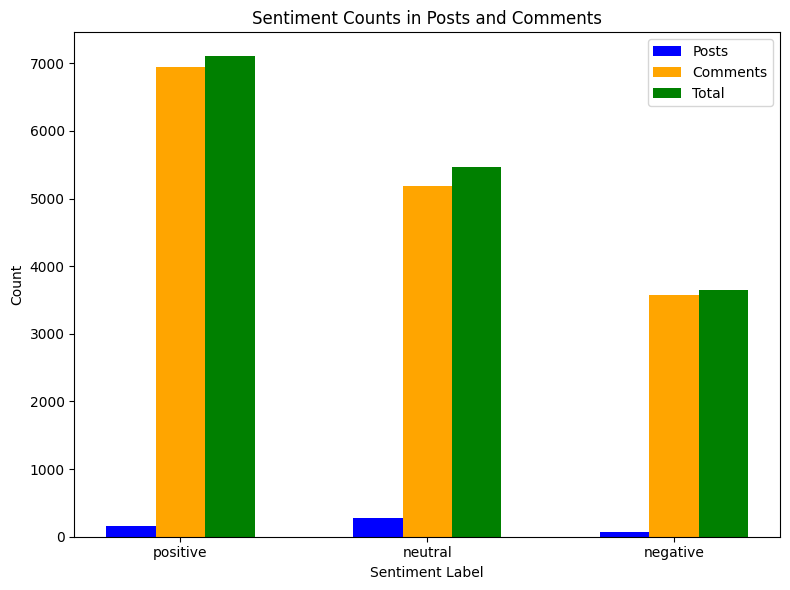

In [182]:
plt.figure(figsize=(8, 6))

bar_width = 0.2
# The bar position on the x-axis
x = range(len(sentiment_count_df['sentiment_label']))

plt.bar(x, sentiment_count_df['post_count'], width=bar_width, label='Posts', color='blue')
plt.bar([i + bar_width for i in x], sentiment_count_df['comment_count'], width=bar_width, label='Comments', color='orange')

plt.bar([i + 2 * bar_width for i in x], sentiment_count_df['total_count'], width=bar_width, label='Total', color='green')

# Set x-axis label
plt.xticks([i + bar_width for i in x], sentiment_count_df['sentiment_label'])

plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Counts in Posts and Comments')
plt.legend()
plt.tight_layout()
plt.show()

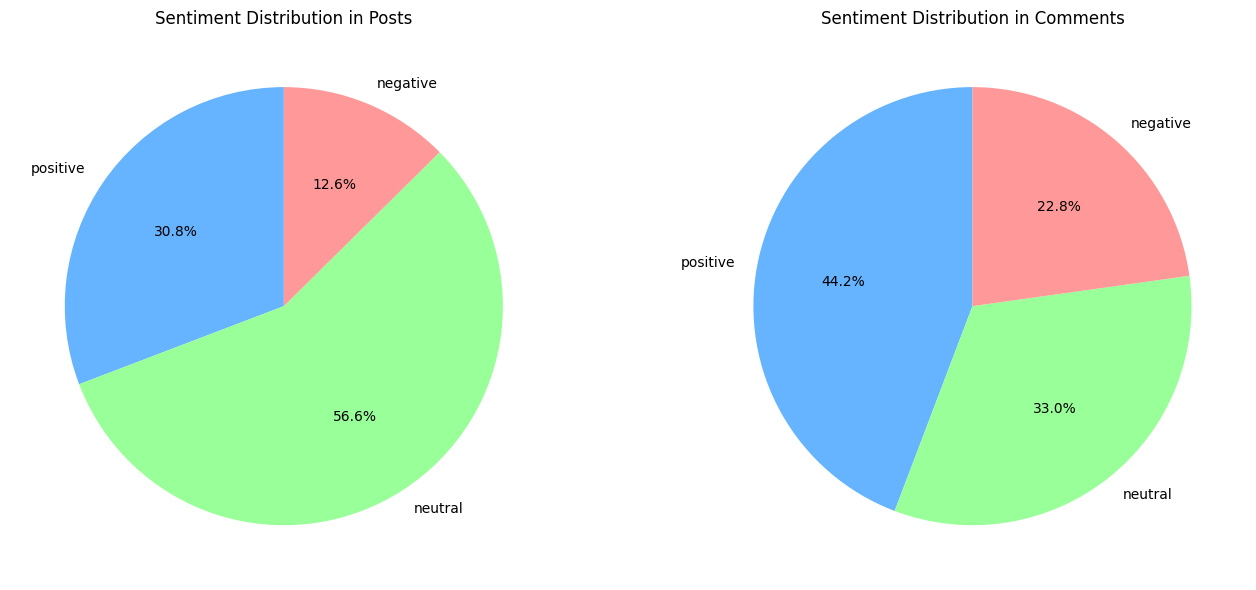

In [208]:
plt.figure(figsize=(14,6))

# plot posts pie chart
plt.subplot(1, 2, 1)
plt.pie(
    sentiment_count_df['post_count'],
    labels=sentiment_count_df['sentiment_label'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#99ff99', '#ff9999']
)
plt.title('Sentiment Distribution in Posts')

# plot comments pie chart
plt.subplot(1, 2, 2)
plt.pie(
    sentiment_count_df['comment_count'],
    labels=sentiment_count_df['sentiment_label'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#99ff99', '#ff9999']
)
plt.title('Sentiment Distribution in Comments')
plt.tight_layout()
plt.show()

Insights:

1. Dominance of Positive Sentiment: The “Total” bars, which sum up posts and comments, show a clear trend where positive sentiments dominate, followed by neutral and then negative. This suggests an overall optimistic tone in the dicussion, which could reflect a positive perception about Bitcoin.

2. Moderate Neutral Sentiments: Neutral sentiments are also frequent, especially in comments, suggesting that many users are engaging in discussions without strong positive or negative emotions, possibly providing factual or balanced responses.

3.	Lower Negative Sentiments: Negative sentiments are less common than positive or neutral ones. This could imply that negative views about the topic are less frequently expressed, or that users are generally less inclined to post negatively.

### Analysis 2: Compound Score
Let's check out the distribution of compound score.

In [212]:
# Get compound_score from posts and comments table
with engine.connect() as conn:
    posts_compound_score_df = pd.read_sql(("""
        SELECT compound_score FROM posts
    """), conn)

    comments_compound_score_df = pd.read_sql(("""
        SELECT compound_score FROM comments
    """), conn)

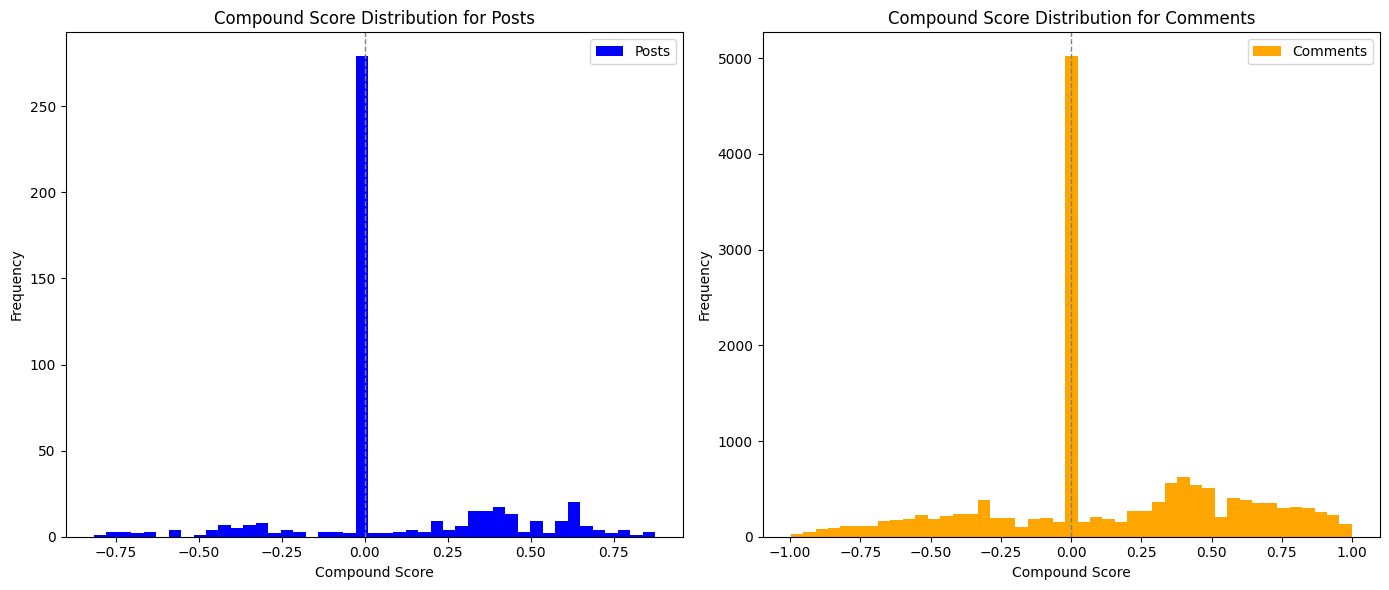

<Figure size 640x480 with 0 Axes>

In [213]:
plt.figure(figsize=(14, 6))

# Plot posts histogram
plt.subplot(1, 2, 1)
plt.hist(posts_compound_score_df['compound_score'], bins=45, label='Posts', color='blue')
plt.title('Compound Score Distribution for Posts')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # 加入基準線，表示中性情感
plt.legend()

# Plot comments histogram
plt.subplot(1, 2, 2)
plt.hist(comments_compound_score_df['compound_score'], bins=45, label='Comments', color='orange')
plt.title('Compound Score Distribution for Comments')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)  # 加入基準線，表示中性情感
plt.legend()

plt.tight_layout()
plt.show()

Insights:

The compound score distributions for posts and comments reveal that most sentiments are neutral, centered around a score of 0. This is especially pronounced in comments, with a large spike in neutral sentiment, indicating that most user discussions lean toward a balanced tone. Both distributions show fewer instances of highly positive or negative sentiments, suggesting that while there are variations, extreme opinions are less common in both posts and comments. Comments generally display a wider range of sentiment than posts, indicating a broader diversity of opinions and emotional responses in user discussions.

### Analysis 3: Positive & Negative WordCloud 
Let's check out the wordcloud in positive sentiment and negative sentiement.

In [217]:
# Get text from both posts and comments
with engine.connect() as conn:
    positive_post_df = pd.read_sql("""
        SELECT post_title FROM posts WHERE sentiment_label = 'positive'
    """, conn)

    positive_comment_df = pd.read_sql("""
        SELECT self_text FROM comments WHERE sentiment_label = 'positive'
    """, conn)

    negative_post_df = pd.read_sql("""
        SELECT post_title FROM posts WHERE sentiment_label = 'negative'
    """, conn)

    negative_comment_df = pd.read_sql("""
        SELECT self_text FROM comments WHERE sentiment_label = 'negative'
    """, conn)

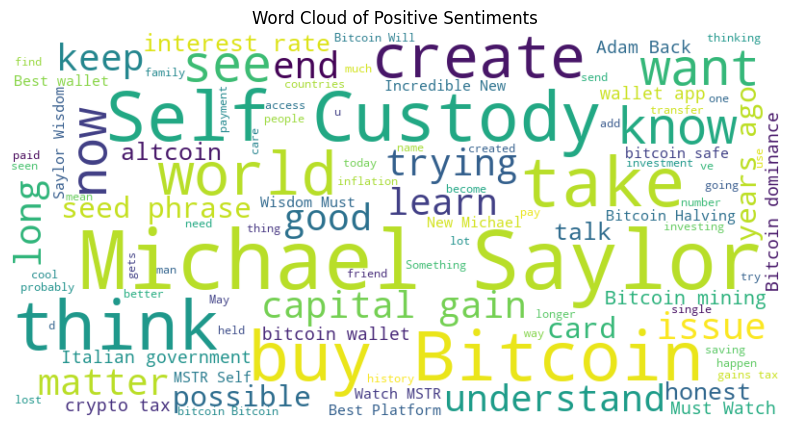

In [216]:
# Merge all positive sentiment text into a string 
text = " ".join(positive_post_df['post_title'])
text = text.join(positive_comment_df['self_text'])

# Init wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

# Plot wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud of Positive Sentiments')
plt.show()

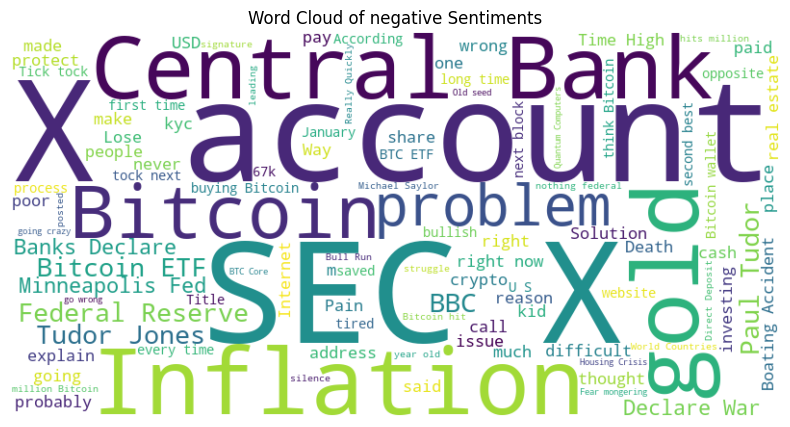

In [218]:
# Merge all negative sentiment text into a string 
text = " ".join(negative_post_df['post_title'])
text = text.join(negative_comment_df['self_text'])

# Init wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

# Plot wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud of negative Sentiments')
plt.show()

Insights:

The word clouds highlight contrasting themes in positive and negative sentiments surrounding Bitcoin discussions. In the positive sentiment cloud, terms like buy Bitcoin reflect optimism about Bitcoin’s investment potential. Interestingly, Self Custody and Michael Saylor also appear in the positive sentiment cloud, suggesting that the public perceives self-custody and Saylor’s recent statements as favorable developments.

The negative sentiment cloud, however, highlights concerns with terms like Central Bank, Inflation, SEC, and problem, suggesting that regulatory pressures, inflation worries, and institutional actions are common sources of concern. This contrast shows a split between enthusiasm for individual control and unease about external economic and regulatory factors.

### Analysis 4: Impact of Post Score on Positive Sentiment Levels
Let's analyze the replationship between post score and its sentiment label.

In [221]:
# Get post_score, compound_score from posts table
with engine.connect() as conn:
    post_scores_df = pd.read_sql("""
        SELECT post_score, compound_score FROM posts
    """, conn)
post_scores_df.head()

,post_score,compound_score
0,36,0.3802
1,1799,0.0000
2,552,0.0000
3,486,0.0000
4,466,0.0000


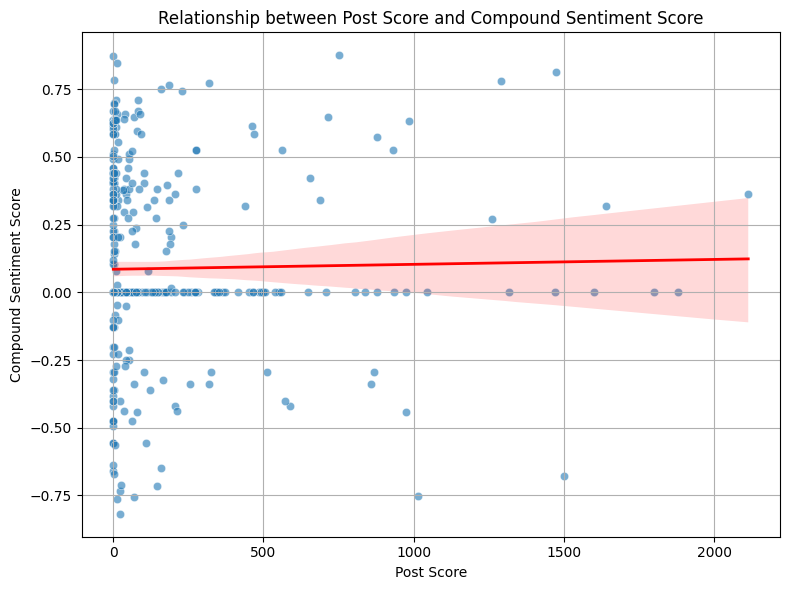

In [222]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=post_scores_df, x='post_score', y='compound_score', alpha=0.6)
# Add regression line
sns.regplot(data=post_scores_df, x='post_score', y='compound_score', scatter=False, color='red', line_kws={"linewidth": 2})

plt.title('Relationship between Post Score and Compound Sentiment Score')
plt.xlabel('Post Score')
plt.ylabel('Compound Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:

1. Weak Correlation: We can see a weak correlation between post score and compound score. Higher post scores don't correspond to more positive or negative sentiment.
   
2. Low-Score Variation: Most posts have low scores(0 - 100) with a wide range of sentiment, from negative to positive.
   
3. Neutral Sentiment: Many posts cluster around a compound_score of 0, indicating a neutral tone.

### Analysis 5: Correlation Between Post Score and Average Sentiment of Comments
Let's examine the relationship between post scores and the average sentiment of their associated comments.

In [226]:
# Get post scores and calculate the average sentiment of their associated comments
with engine.connect() as conn:
    comments_avg_sentiment_df = pd.read_sql("""
        SELECT p.post_score, c.comments_avg_sentiment
        FROM posts p
        JOIN (
            SELECT post_id, AVG(compound_score) AS comments_avg_sentiment
            FROM comments 
            GROUP BY post_id
        ) c ON p.post_id = c.post_id
    """, conn)

comments_avg_sentiment_df.head()

,post_score,comments_avg_sentiment
0,36,0.966100
1,1799,-0.063075
2,552,0.108243
3,486,0.123246
4,466,0.093457


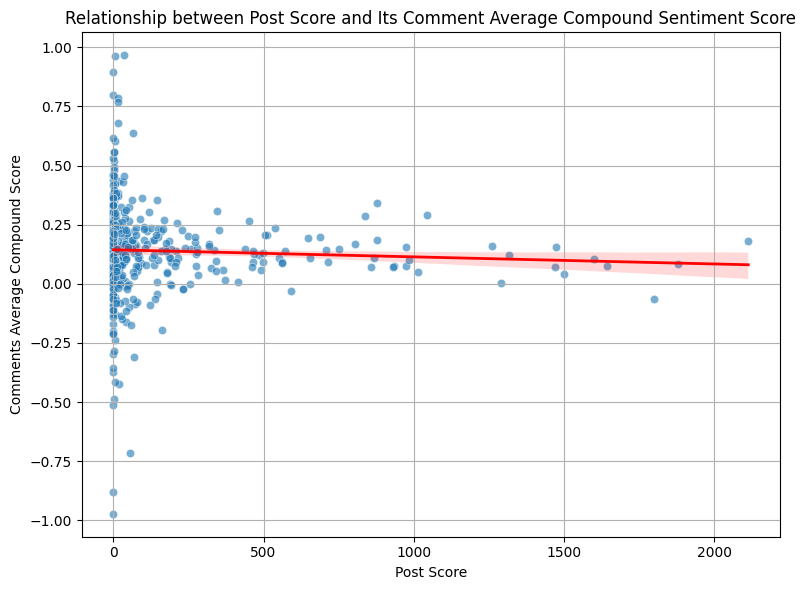

In [227]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=comments_avg_sentiment_df, x='post_score', y='comments_avg_sentiment', alpha=0.6)
# Add regression line
sns.regplot(data=comments_avg_sentiment_df, x='post_score', y='comments_avg_sentiment', scatter=False, color='red', line_kws={"linewidth": 2})

plt.title('Relationship between Post Score and Its Comment Average Compound Score')
plt.xlabel('Post Score')
plt.ylabel('Comments Average Compound Score of Each Post')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:

The scatter plot shows a weak and slightly negative correlation between post scores and the average sentiment of their comments. Most posts, regardless of score, have comments with sentiment scores clustered around neutral (0). As post scores increase, there doesn’t appear to be a significant shift towards more positive or negative comment sentiment. This suggests that highly upvoted posts do not necessarily generate more positive or negative discussions; rather, sentiment remains balanced across different engagement levels.

### Analysis 6: Link Between Post Score and Comment Count
Let's check out the relationship between post scores and their associated comment count.

In [228]:
with engine.connect() as conn:
    post_score_and_comments_count_df = pd.read_sql("""
        SELECT post_score, post_num_comments FROM posts
    """, conn)
post_score_and_comments_count_df.head()

,post_score,post_num_comments
0,36,13
1,1799,95
2,552,172
3,486,82
4,466,192


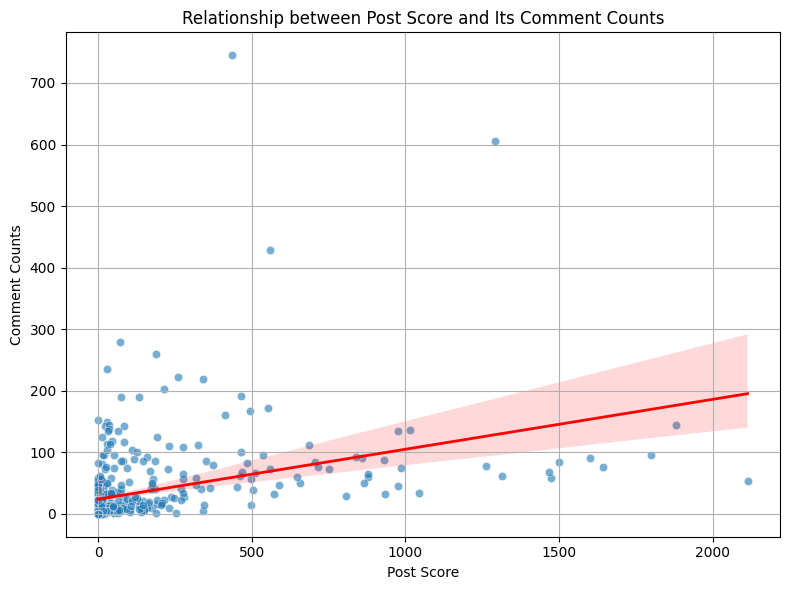

In [229]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=post_score_and_comments_count_df, x='post_score', y='post_num_comments', alpha=0.6)
# Add regression line
sns.regplot(data=post_score_and_comments_count_df, x='post_score', y='post_num_comments', scatter=False, color='red', line_kws={"linewidth": 2})

plt.title('Relationship between Post Score and Its Comment Counts')
plt.xlabel('Post Score')
plt.ylabel('Comment Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights:

The scatter plot indicates a positive correlation between post scores and the number of comments. As post scores increase, the number of comments generally rises as well, suggesting that more upvoted posts tend to attract more discussion. However, there are a few outliers where posts with relatively high scores have an unusually high or low number of comments, indicating that factors other than score may also influence engagement levels. Overall, this trend suggests that highly upvoted posts are more likely to spark interaction within the community.